# **Hybrid Normalization**
Lightweight implementation of hybrid normalization - proposes an intuitive normalization method that integrates the strength of both Pre-Normalization (i.e QKV-Norm in MHA) and Post-Normalization in the feed-forward network, leading to stability in training and improved model performance.
At the attention level **HybridNorm** attention is given as:

$$
\text{MHA}_{QKV}(X^l) = \text{softmax} \left( \frac{\text{Norm}(Q^l) \text{Norm}(K^l)^T}{\sqrt{d_k}} \right) \text{Norm}(V^l)
$$

$$
Y^l = \text{MHA}_{QKV} (X^l) + X^l
$$

$$
X^{l+1} = \text{FFN} (\text{Norm}(Y^l)) + \text{Norm}(Y^l)
$$


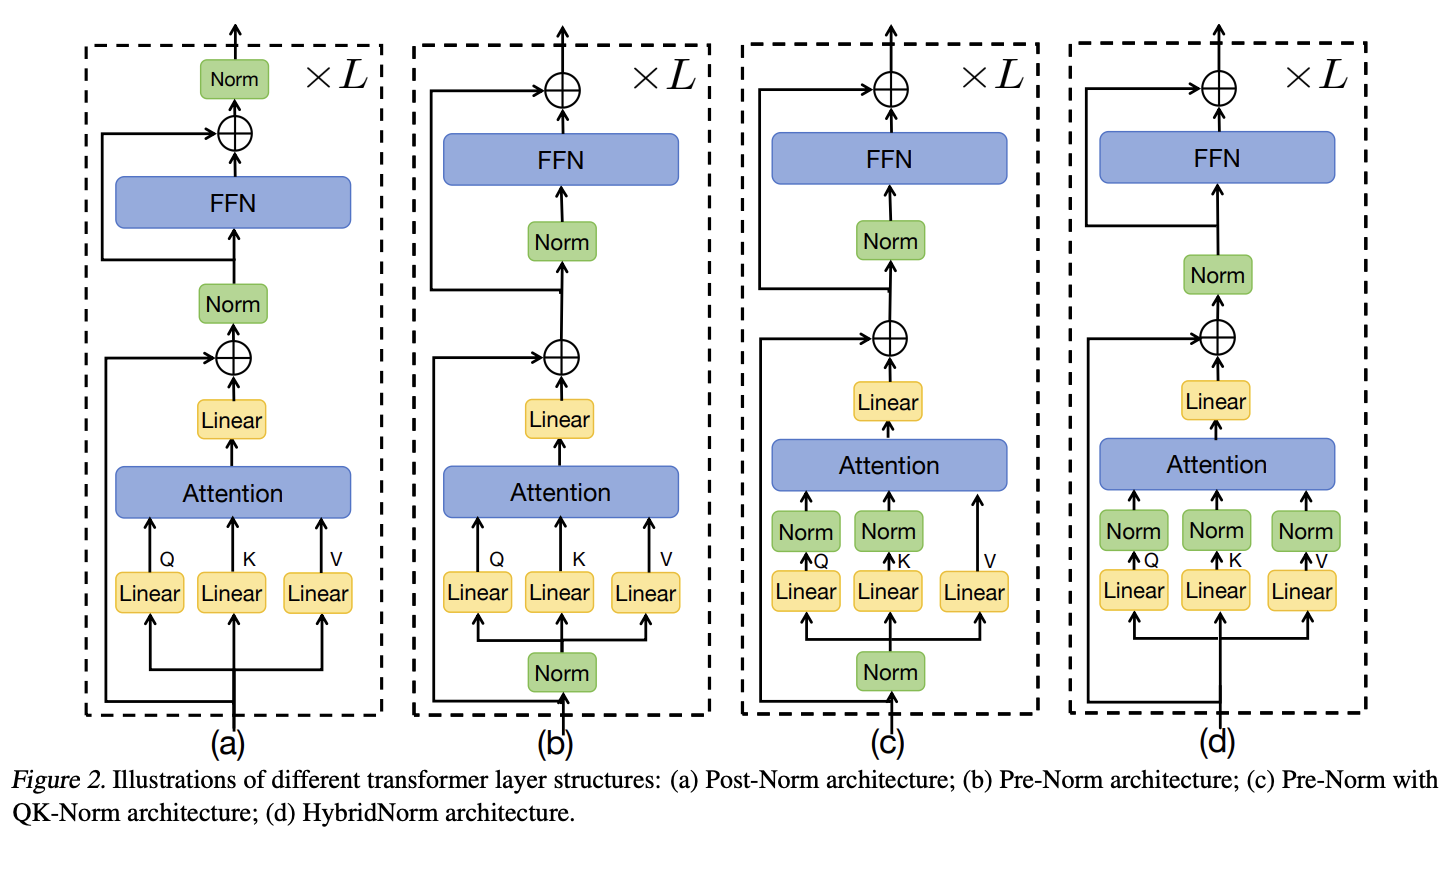

[PRE-NORM] Step: 1/200 | train loss: 4.34 | val loss: 3.87
[PRE-NORM] Step: 2/200 | train loss: 3.90 | val loss: 3.62
[PRE-NORM] Step: 3/200 | train loss: 3.65 | val loss: 3.61
[PRE-NORM] Step: 4/200 | train loss: 3.63 | val loss: 3.58
[PRE-NORM] Step: 5/200 | train loss: 3.60 | val loss: 3.45
[PRE-NORM] Step: 6/200 | train loss: 3.47 | val loss: 3.40
[PRE-NORM] Step: 7/200 | train loss: 3.40 | val loss: 3.37
[PRE-NORM] Step: 8/200 | train loss: 3.36 | val loss: 3.35
[PRE-NORM] Step: 9/200 | train loss: 3.44 | val loss: 3.36
[PRE-NORM] Step: 10/200 | train loss: 3.40 | val loss: 3.35
[PRE-NORM] Step: 11/200 | train loss: 3.45 | val loss: 3.36
[PRE-NORM] Step: 12/200 | train loss: 3.38 | val loss: 3.37
[PRE-NORM] Step: 13/200 | train loss: 3.36 | val loss: 3.33
[PRE-NORM] Step: 14/200 | train loss: 3.36 | val loss: 3.36
[PRE-NORM] Step: 15/200 | train loss: 3.31 | val loss: 3.32
[PRE-NORM] Step: 16/200 | train loss: 3.36 | val loss: 3.37
[PRE-NORM] Step: 17/200 | train loss: 3.38 | val 

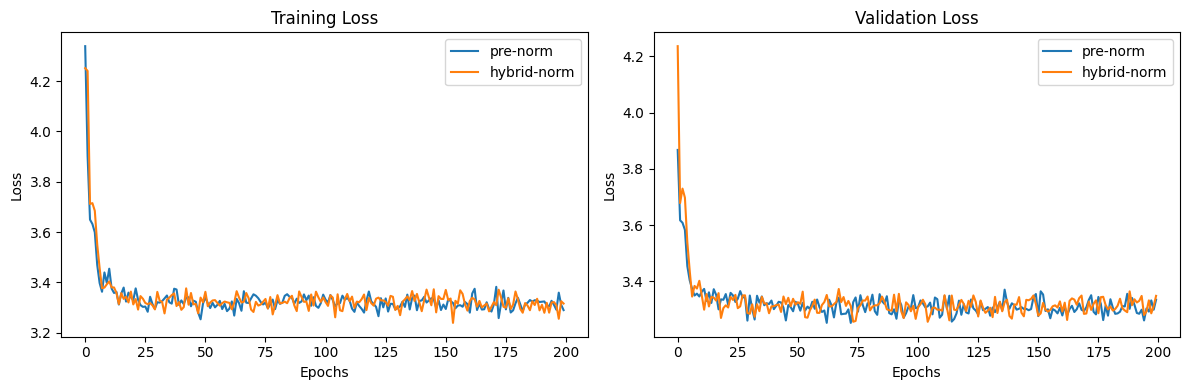

/var/folders/lv/fs2j5vr90zz71f7mbvytr3s80000gn/T/ipykernel_89600/3284027310.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'nanogpt_


PRE-NORM SAMPLE

First Citizen:i
,T
 niubtyO mnoRro opnerwf'hwirre
   tft thrs,ib ouaosr  ntleyhaadc dCy
ndt 
e.rMtto,O:wa
 enltciu

HYBRID-NORM SAMPLE

First Citizen:rrraiocnheior'nhel aeptmhdda
nrhlW aa endbmsF OdteT ht FrnlT aeshac
AtadI Hwsets,.e,
I
deea hiHraGeS


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and prep data
with open('tinyshakespeare.txt', 'r') as f:
    text = f.read()
chars = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
data = torch.tensor([stoi[ch] for ch in text], dtype=torch.long)
train_size = int(0.9 * len(data))
train_data, val_data = random_split(data, [train_size, len(data) - train_size])

# Hyperparameters
vocab_size = 65
dim = 384
num_heads = 6
num_layers = 6
seq_length = 256
dropout = 0.1
batch_size = 6
learning_rate = 3e-4
num_epochs = 200
grad_accumulation_steps = 4  

# Batch generator
def get_batch(split):
    dataset = train_data if split == 'train' else val_data
    ix = torch.randint(len(dataset) - seq_length, (batch_size,))
    x = torch.stack([dataset[i:i+seq_length] for i in ix]).to(device)
    y = torch.stack([dataset[i+1:i+seq_length+1] for i in ix]).to(device)
    return x, y

# Transformer Block with Pre-Norm and HybridNorm
class TransformerBlock(nn.Module):
    def __init__(self, dim, norm_type):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(nn.Linear(dim, 4 * dim), nn.ReLU(), nn.Linear(4 * dim, dim), nn.Dropout(dropout))
        self.norm_type = norm_type
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)

    def forward(self, x):
        if self.norm_type == 'hybrid':  # HybridNorm: QKV Norm + Post-Norm in FFN
            q, k, v = [self.ln1(x) for _ in range(3)]
            attn_out, _ = self.attn(q, k, v)
            x = attn_out + x
            x = self.ln2(self.ff(x) + x)  # Post-Norm in FFN
        else:  # Pre-Norm
            attn_out, _ = self.attn(self.ln1(x), self.ln1(x), self.ln1(x))
            x = attn_out + x
            x = self.ff(self.ln2(x)) + x
        return x

# nanoGPT Model
class nanoGPT(nn.Module):
    def __init__(self, norm_type='pre'):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(dim, norm_type) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits

# Initialize models
models = {'pre-norm': nanoGPT('pre').to(device), 'hybrid-norm': nanoGPT('hybrid').to(device)}
losses = {'train': {'pre-norm': [], 'hybrid-norm': []}, 'val': {'pre-norm': [], 'hybrid-norm': []}}
optimizers = {name: torch.optim.AdamW(model.parameters(), lr=learning_rate) for name, model in models.items()}

# Train
for norm, model in models.items():
    model.train()
    for epoch in range(1, num_epochs + 1):
        total_loss = 0
        optimizer = optimizers[norm]
        optimizer.zero_grad()

        for step in range(grad_accumulation_steps):  # Accumulate gradients
            xb, yb = get_batch('train')
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1)) / grad_accumulation_steps
            loss.backward()
            total_loss += loss.item()

        optimizer.step()  # Update weights
        optimizer.zero_grad()

        # Validation
        model.eval()
        xb, yb = get_batch('val')
        with torch.no_grad():
            val_logits = model(xb)
            val_loss = F.cross_entropy(val_logits.view(-1, vocab_size), yb.view(-1))
        
        losses['train'][norm].append(total_loss)
        losses['val'][norm].append(val_loss.item())

        # Log loss per step
        print(f"[{norm.upper()}] Step: {epoch}/{num_epochs} | Train Loss: {total_loss:.2f} | Val Loss: {val_loss.item():.2f}")
        
        model.train()

# Save models
for norm, model in models.items():
    torch.save(model.state_dict(), f'nanogpt_{norm}.pth')

# Text generation function
def generate_text(model, start_str='First Citizen:', length=200):
    model.eval()
    input_seq = torch.tensor([[stoi[c] for c in start_str]], dtype=torch.long).to(device)
    generated = start_str
    for _ in range(length):
        logits = model(input_seq)[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        next_char = torch.multinomial(probs, 1).item()
        generated += itos[next_char]
        input_seq = torch.cat([input_seq, torch.tensor([[next_char]], device=device)], dim=-1)
    return generated

# Plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for norm in ['pre-norm', 'hybrid-norm']:
    axs[0].plot(losses['train'][norm], label=norm)
    axs[1].plot(losses['val'][norm], label=norm)
axs[0].set_title('Training Loss')
axs[1].set_title('Validation Loss')
for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
plt.tight_layout()
plt.show()

# Generate samples
for norm in ['pre-norm', 'hybrid-norm']:
    model = nanoGPT(norm).to(device)
    model.load_state_dict(torch.load(f'nanogpt_{norm}.pth'))
    print(f"\n{'='*50}\n{norm.upper()} SAMPLE\n{'='*50}\n")
    print(generate_text(model))
